In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys import ecephys_session
%matplotlib inline

# fix slow autocomplete
%config Completer.use_jedi = False

In [2]:
import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # OS X 
    data_root = "/Volumes/Brain2019/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn1' in platstring):
    # then on AWS
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2019/"

manifest_path = os.path.join(data_root, "dynamic-brain-workshop/visual_coding_neuropixels/2019/manifest.json")

In [3]:
cache = EcephysProjectCache.fixed(manifest=manifest_path)
sessions = cache.get_sessions()

In [4]:
import sys
sys.path.append('../../swdb_2019_tools')
import ecephys_utilities
import spikeutils
import stim_presentation_FR

In [107]:
#Choose a session that has V1 (ultimately re-run analyses for all sessions that have V1, given that all sessions have DG and CA)
#Get info for that session
sessionID = sessions.index[1]
session = cache.get_session_data(sessions.index[1])

In [17]:
regions = ['VISp']

In [18]:
#Find probe ID(s) that went through V1
probeID = session.units.probe_id[(session.units.structure_acronym.isin(regions))].unique()[0]

In [19]:
probeID

757968493

In [20]:
#Use THAT probe to pull out LFPs and spikes for DG, CA, V1 
#(once pipeline working, also incorporate other probes for CA/DG)

#Pull probe with lfps
session_lfps_from_probeid = session.get_lfp(probeID)

In [21]:
#pull lfps from channel on probe that correspond to different regions and add to dataframe
lfps_across_regions_df = pd.DataFrame()
for chanid in session_lfps_from_probeid['channel'].values:
    for region in ['VISp', 'CA', 'DG']:
        region_lfps = []
        region_lfp_channel_ids = []
        region_channels_on_probe = session.channels[(session.channels.probe_id == probeID) & 
                                                    (session.channels.manual_structure_acronym == region)]
        if region_channels_on_probe.index.contains(chanid):
            region_lfp_channel_ids.append(chanid)
            region_lfps.append(session_lfps_from_probeid.loc[{'channel': chanid}].values)
        region_lfps_df = pd.DataFrame({"lfps": region_lfps}, index=pd.Index(data=region_lfp_channel_ids, name="channel_id"))
        region_lfps_df['region'] = region
        lfps_across_regions_df = lfps_across_regions_df.append(region_lfps_df)

session_lfps_from_probeid = None

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: The 'contains' method is deprecated and will be removed in a future version. Use 'key in index' instead of 'index.contains(key)'


In [22]:
#merge lfp dataframe with other session info about probe position
lfps_across_regions_df = pd.merge(lfps_across_regions_df, 
         session.channels.loc[:, 'probe_id':'probe_vertical_position'], 
         left_on=lfps_across_regions_df.index, 
         right_on = session.channels.index,
        how = 'left')
lfps_across_regions_df = lfps_across_regions_df.rename(columns={"key_0": "channel_id"})

In [ ]:
#Stimulus presentations:

#Grab stimulus presentation info for session
#Use session.get_presentations_for_stimulus
#Use session.get_stimulus_epochs

#Pull out start times, -10 to 500 for each presentation of given stimulus type
#Look at session.conditionwise_spike_statistics method

In [32]:
stim_epochs = session.get_stimulus_epochs()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [33]:
stim_epochs.groupby("stimulus_name").count()

,start_time,stop_time,duration,stimulus_block
stimulus_name,,,,
drifting_gratings,3,3,3,3
flashes,1,1,1,1
gabors,1,1,1,1
natural_movie_one,2,2,2,2
natural_movie_three,2,2,2,2
natural_scenes,3,3,3,3
spontaneous,15,15,15,15
static_gratings,3,3,3,3


In [34]:
drifting_gratings_start_times = list(session.stimulus_presentations[session.stimulus_presentations.stimulus_name == 'drifting_gratings'].start_time)

In [35]:
flashes_start_times = list(session.stimulus_presentations[session.stimulus_presentations.stimulus_name == "flashes"].start_time)

In [36]:
#Natural movie 1 is ~30 seconds long
natural_movie_one_start_times = list(session.stimulus_presentations[(session.stimulus_presentations.stimulus_name == "natural_movie_one") & (session.stimulus_presentations.frame == 1)].start_time)

In [37]:
natural_movie_three_start_times = list(session.stimulus_presentations[(session.stimulus_presentations.stimulus_name == "natural_movie_three") & (session.stimulus_presentations.frame == 1)].start_time)

In [38]:
natural_scenes_start_times = list(session.stimulus_presentations[session.stimulus_presentations.stimulus_name == 'natural_scenes'])

In [39]:
spontaneous_start_times = list(session.stimulus_presentations[session.stimulus_presentations.stimulus_name == 'spontaneous'].start_time)

In [40]:
static_gratings_start_times = list(session.stimulus_presentations[session.stimulus_presentations.stimulus_name == 'static_gratings'].start_time)

In [98]:
import scipy.signal
from matplotlib import cm

VISp_lfp_index = int(lfps_across_regions_df[lfps_across_regions_df.region == "VISp"].index.max())//2
CA_lfp_index = int(lfps_across_regions_df[lfps_across_regions_df.region == "CA"].index.max())//2
DG_lfp_index = int(lfps_across_regions_df[lfps_across_regions_df.region == "DG"].index.max())//2

fs = 2500

#Gather info for plot
plot_start_time = natural_movie_one_start_times[0] - 1 #in seconds
plot_end_time = natural_movie_one_start_times[0] + 2 #in seconds
t = np.arange(plot_start_time, plot_end_time, 1/fs)
lfp_start_index = int(plot_start_time*fs)
lfp_end_index = int(plot_end_time*fs)

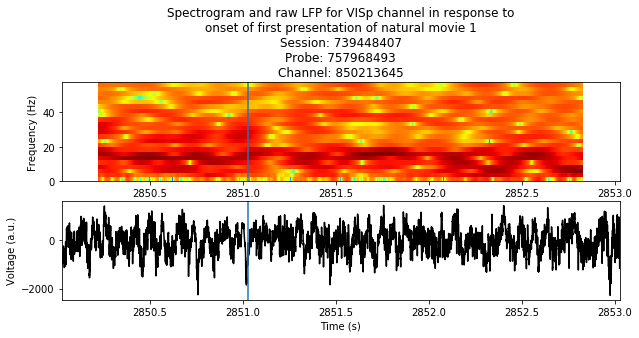

In [119]:
#Spectrogram for VISp

f, t_spec, spec = scipy.signal.spectrogram(lfps_across_regions_df.lfps[VISp_lfp_index][lfp_start_index:lfp_end_index], fs=fs, window='hanning', nperseg=1000, noverlap=1000-1, mode='psd')
# Scipy assumes our signal starts at time=0, so we need to provide the offset
t_spec = t_spec + t[0]
fmax = 60
x, y = t_spec, f[f<fmax]
plot_data = np.log10(spec[f<fmax])


fig, ax = plt.subplots(2, 1, figsize=(10,4))

plt.subplot(2,1,1)
plt.pcolormesh(x, y, plot_data, cmap=cm.jet)
window = [plot_start_time,plot_end_time]
plt.xlim(window)
plt.ylabel('Frequency (Hz)')
plt.axvline(x=natural_movie_one_start_times[0])
plt.title('Spectrogram and raw LFP for VISp channel in response to\n' +
    'onset of first presentation of natural movie 1\nSession: {}\nProbe: {}\nChannel: {}'.format(sessionID, 
                                                                                                 probeID, 
                                                                                                 lfps_across_regions_df.channel_id[VISp_lfp_index]))

plt.subplot(2,1,2)
plt.plot(t, lfps_across_regions_df.lfps[VISp_lfp_index][lfp_start_index:lfp_end_index], 'k')
plt.xlim(window)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (a.u.)')
plt.axvline(x=natural_movie_one_start_times[0])
plt.show()
fig.savefig('VISp LFP and Spectrogram to natural movie 1 in session{}_probe{}_channel{}.png'.format(sessionID, 
                                                                                                    probeID, 
                                                                                                    lfps_across_regions_df.channel_id[VISp_lfp_index]), 
            dpi = 300)

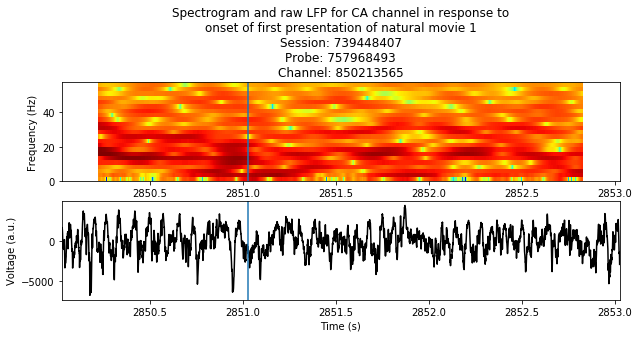

In [120]:
#Spectrogram for CA

f, t_spec, spec = scipy.signal.spectrogram(lfps_across_regions_df.lfps[CA_lfp_index][lfp_start_index:lfp_end_index], fs=fs, window='hanning', nperseg=1000, noverlap=1000-1, mode='psd')
# Scipy assumes our signal starts at time=0, so we need to provide the offset
t_spec = t_spec + t[0]
fmax = 60
x, y = t_spec, f[f<fmax]
plot_data = np.log10(spec[f<fmax])


fig, ax = plt.subplots(2, 1, figsize=(10,4))

plt.subplot(2,1,1)
plt.pcolormesh(x, y, plot_data, cmap=cm.jet)
window = [plot_start_time,plot_end_time]
plt.xlim(window)
plt.ylabel('Frequency (Hz)')
plt.axvline(x=natural_movie_one_start_times[0])
plt.title('Spectrogram and raw LFP for CA channel in response to\n' +
    'onset of first presentation of natural movie 1\nSession: {}\nProbe: {}\nChannel: {}'.format(sessionID, 
                                                                                                 probeID, 
                                                                                                 lfps_across_regions_df.channel_id[CA_lfp_index]))

plt.subplot(2,1,2)
plt.plot(t, lfps_across_regions_df.lfps[CA_lfp_index][lfp_start_index:lfp_end_index], 'k')
plt.xlim(window)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (a.u.)')
plt.axvline(x=natural_movie_one_start_times[0])
plt.show()
fig.savefig('CA LFP and Spectrogram to natural movie 1 in session{}_probe{}_channel{}.png'.format(sessionID, 
                                                                                                    probeID, 
                                                                                                    lfps_across_regions_df.channel_id[CA_lfp_index]), 
            dpi = 300)

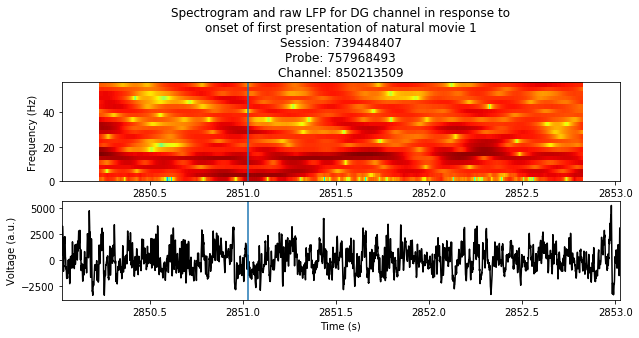

In [121]:
#Spectrogram for DG

f, t_spec, spec = scipy.signal.spectrogram(lfps_across_regions_df.lfps[DG_lfp_index][lfp_start_index:lfp_end_index], 
                                           fs=fs, window='hanning', nperseg=1000, noverlap=1000-1, mode='psd')
# Scipy assumes our signal starts at time=0, so we need to provide the offset
t_spec = t_spec + t[0]
fmax = 60
x, y = t_spec, f[f<fmax]
plot_data = np.log10(spec[f<fmax])


fig, ax = plt.subplots(2, 1, figsize=(10,4))

plt.subplot(2,1,1)
plt.pcolormesh(x, y, plot_data, cmap=cm.jet)
window = [plot_start_time,plot_end_time]
plt.xlim(window)
plt.ylabel('Frequency (Hz)')
plt.axvline(x=natural_movie_one_start_times[0])
plt.title('Spectrogram and raw LFP for DG channel in response to\n' +
    'onset of first presentation of natural movie 1\nSession: {}\nProbe: {}\nChannel: {}'.format(sessionID, 
                                                                                                 probeID, 
                                                                                                 lfps_across_regions_df.channel_id[DG_lfp_index]))

plt.subplot(2,1,2)
plt.plot(t, lfps_across_regions_df.lfps[DG_lfp_index][lfp_start_index:lfp_end_index], 'k')
plt.xlim(window)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (a.u.)')
plt.axvline(x=natural_movie_one_start_times[0])
plt.show()
fig.savefig('DG LFP and Spectrogram to natural movie 1 in session{}_probe{}_channel{}.png'.format(sessionID, 
                                                                                                    probeID, 
                                                                                                    lfps_across_regions_df.channel_id[DG_lfp_index]), 
            dpi = 300)

In [ ]:
#PSTH (post stimulus spike trains) from -10 to 500 in V1 and hippo
#Use session.presentationwise_spike_counts
#Use session.presentationwise_spike_times

In [ ]:
#Look at relationship between stimulus-evoked theta phase/amplitude and spikes within hippo between hippo and V1

#For LFPs:
    #bandpass filter to theta frequency using butterworth filter
    #Calculate instantaneous amplitude and phase of theta using hilbert
    #Calculate averaged evoked response 
        #(sum all LFP values within channel across presentations and divide by n presentations)
        #Calculate average latency (peak of LFP evoked response post-stimulus)
        
#For spikes:
    #Calculate smoothed firing rate binned into theta phase (4 bins to 10 bins per second)- use for correlations with spikes and LFPs
    #Calculate smoothed firing rate before/after stimulus presentations into smaller (1ms) bins
        #(sum firing rates across presentations then divide by number of presentations)
        #Calculate average latency (peak of firing rate post-stimulus)

#Look at correlation matrix within CA/DG instantaneous phase/amplitude + firing rates
#Look at correlation matrix between CA/DG instantaneous phase/amplitude + V1 phase/amplitude
#Look at correlation matrix between CA/DG firing rates + V1 firing rates
#Look at correlation matrix between CA/DG instantaneous phase/amplitude +V1 firing rates

#Identify units that correlate and those that don't (threshold r value?), characterize %FS vs. RSU

In [ ]:
#bandpass filter to theta frequency using butterworth filter
import scipy.signal
freq_window = (4, 10)
filt_order = 3
fs = 2500
b, a = scipy.signal.butter(filt_order, freq_window, btype='bandpass', fs=fs)

In [ ]:
theta_filtered = []
for i in lfps_across_regions_df.index:
    lfp = lfps_across_regions_df.lfps[i]
    theta = scipy.signal.lfilter(b, a, lfp)
    theta_filtered.append(theta)
lfps_across_regions_df['theta_filtered_lfps'] = theta_filtered

In [ ]:
#downsample lfps and theta_filtered lfps
lfps_downsampled = []
theta_filtered_downsampled = []
for i in lfps_across_regions_df.index:
    lfps_downsampled.append(scipy.signal.decimate(lfps_across_regions_df.lfps[i], q = 4, ftype = 'iir'))
    theta_filtered_downsampled.append(scipy.signal.decimate(lfps_across_regions_df.theta_filtered_lfps[i], q = 4, ftype = 'iir'))


In [ ]:
lfps_across_regions_df['lfps_downsampled'] = lfps_downsampled
lfps_across_regions_df['theta_downsampled'] = theta_filtered_downsampled

In [ ]:
#Plot LFPs across regions:
fs = 625

#Gather info for plot
plot_start_time = 5 #in seconds
plot_end_time = 10 #in seconds
t = np.arange(plot_start_time, plot_end_time, 1/fs)
lfp_start_index = int(plot_start_time*fs)
lfp_end_index = int(plot_end_time*fs)

#Make plot
plt.figure(figsize=(10, 10))
for region in ['DG', 'CA', 'VIS']:
    subsample = []
    subsample.append(int(lfps_across_regions_df[lfps_across_regions_df.region == region].index.max())/2)
    for i in subsample:
        plt.plot(t, lfps_across_regions_df.theta_downsampled[i][lfp_start_index:lfp_end_index]/3 - lfps_across_regions_df.probe_vertical_position[i])

In [ ]:
#Calculate instantaneous amplitude and phase of theta using hilbert
theta_hilbert = []
theta_envelope = []
theta_phase = []
theta_cosine = []
for i in lfps_across_regions_df.index:
    hil_sig = scipy.signal.hilbert(lfps_across_regions_df.theta_downsampled[i])
    theta_hilbert.append(hil_sig)
    theta_envelope.append(np.abs(hil_sig))
    theta_phase.append(np.angle(hil_sig))
    theta_cosine.append(np.cos(np.unwrap(np.angle(hil_sig))))

In [ ]:
lfps_across_regions_df['theta_hilbert_signal'] = theta_hilbert
lfps_across_regions_df['theta_envelope'] = theta_envelope
lfps_across_regions_df['theta_phase'] = theta_phase
lfps_across_regions_df['theta_cosine'] = theta_cosine

In [ ]:
#Plot LFPs across regions:
fs = 625

#Gather info for plot
plot_start_time = 5 #in seconds
plot_end_time = 10 #in seconds
t = np.arange(plot_start_time, plot_end_time, 1/fs)
lfp_start_index = int(plot_start_time*fs)
lfp_end_index = int(plot_end_time*fs)

#Make plot
plt.figure(figsize=(10, 10))
for region in ['DG', 'CA', 'VIS']:
    subsample = []
    subsample.append(int(lfps_across_regions_df[lfps_across_regions_df.region == region].index.max())/2)
    for i in subsample:
        plt.plot(t, lfps_across_regions_df.theta_envelope[i][lfp_start_index:lfp_end_index] - lfps_across_regions_df.probe_vertical_position[i])

In [ ]:
session_spikes_df = ecephys_utilities.spike_times_to_dataframe(spike_times=session_spikes)

In [ ]:
session_spikes_df = pd.merge(session_spikes_df, session_info.units, left_on = session_spikes_df.index, right_on = session_info.units.index, how = "left")

In [ ]:
session_spikes_df.head()

In [ ]:
session_info.get_presentations_for_stimulus("spontaneous")

In [ ]:
stim_presentation_FR.stim_presentation_FR(session=session_info, stimulus='gabors')

In [ ]:
regions = ['DG', 'CA', 'VIS']

In [ ]:
sessionIDs = sessions.index[sessions.genotype == 'wt'][6:8]

In [ ]:
for sessionID in sessionIDs:
    print(sessionID)

In [ ]:
DG_CA_VIS_spikes = Neuropixels_spike_timeseries.get_spike_timeseries_to_df(cache=cache, sessionIDs=sessionIDs, regions = regions)

In [ ]:
session_info = cache.get_session_data(sessions.index[sessions.genotype == 'wt'][7])

In [ ]:
session_ca_channels = session_info.channels.index[session_info.channels.manual_structure_acronym == 'CA']

In [ ]:
session_ca_units = session_info.units.index[session_info.units.peak_channel_id.isin(session_ca_channels)]

In [ ]:
session_spikes = session_info.spike_times

In [ ]:
session_ca_spikes = []
for unit in session_ca_units:
    session_ca_spikes.append(session_spikes[unit])

In [ ]:
ca_rsu_units, ca_fs_units = spikeutils.fs_rsu_split(units_to_split=session_info.units[session_info.units.peak_channel_id.isin(session_ca_channels)], cutoff=.55, return_hist=True)

In [ ]:
ca_fs_units.firing_rate.mean()

In [ ]:
ca_rsu_units.firing_rate.mean()

In [ ]:
ca_fs_spikes = [session_spikes[unit] for unit in ca_fs_units.index]

In [ ]:
len(ca_fs_spikes)

In [ ]:
len(ca_fs_units)

In [ ]:
spikeutils.spiketimes_to_firingrate?

In [ ]:
session_presentations = session_info.get_stimulus_epochs()

In [ ]:
session_presentations.head()

In [ ]:
resting = session_presentations[session_presentations.stimulus_name == 'spontaneous']

In [ ]:
gabors = session_presentations[session_presentations.stimulus_name == 'gabors']

In [ ]:
numunits = len(ca_fs_units)
numbins = int(np.ceil(ca_fs_spikes[12].max()))

In [ ]:
print(numunits)
print(numbins)

In [ ]:

ca_fs_binned = np.empty((numunits, numbins))
for i in range(numunits):
    spikes = ca_fs_spikes[i]
    for j in range(numbins):
        ca_fs_spikes[i,j] = len(spikes[(spikes>j)&(spikes<j+1)]) 

In [ ]:
resting_FR_fsunits_ca = []

In [ ]:
gabors_FR_fsunits_ca = []

In [ ]:
for unit in range(0, len(ca_fs_spikes)):
    for period in gabors.index:
        starttime = gabors.start_time[period]
        stoptime = gabors.stop_time[period]
        fs_unit_firingrate = spikeutils.spiketimes_to_firingrate(binsize = 1, spiketimes = ca_fs_spikes[2], startime=starttime, stoptime=stoptime, binarize=False)
        gabors_FR_fsunits_ca.append(fs_unit_firingrate)

In [ ]:
ca_fs_spikes[1]

In [ ]:
plt.plot(ca_fs_spikes[12], np.repeat(0,len(ca_fs_spikes[12])), '|')

In [ ]:
import scipy.signal
freq_window = (4, 10)
filt_order = 3
fs = 2500
b, a = scipy.signal.butter(filt_order, freq_window, btype='bandpass', fs=fs)

In [ ]:
print(a.shape)
print(b.shape)


In [ ]:
plt.plot(hc_to_v1_lfps.lfp_timeseries[0].to_numpy()[1])

In [ ]:
type(hc_to_v1_lfps.lfp_timeseries)

In [ ]:
lfp_theta = scipy.signal.lfilter(b, a, hc_to_v1_lfps.lfp_timeseries[0].to_numpy())
#ca_theta = scipy.signal.lfilter(b, a, ca)
#dg_theta = scipy.signal.lfilter(b, a, dg)

In [ ]:
cross_region_lfps = [v1_theta, ca_theta, dg_theta]
cross_region_labels = ['v1', 'ca', 'dg']
timevec = np.arange(0, 12500*2500, 2500)

In [ ]:
plt.subplots(figsize = (10, 10))
for i in range(len(cross_region_lfps)):
    plt.plot(cross_region_lfps[i][:12500] - i*cross_region_lfps[i][:12500].max(), label = cross_region_labels[i])
plt.legend(loc = 'lower right')
plt.xlabel('timestep in 2500 Hz sampling rate')
plt.ylabel('LFP (mV)')
plt.savefig('single_lfps.png', dpi = 300)
#plt.plot(v1_theta[:12500], color = 'black')
#plt.plot(ca_theta[:12500], color = 'red')
#plt.plot(dg_theta[:12500], color = 'blue')

In [ ]:
timeseries = []
for key, value in ca_lfps.items():
    timeseries.append(len(value))

In [ ]:
#ca_channels_lfp = probe_lfp.loc[dict(channel=probe_lfp.channel.isin(ca_channelinfo.index))]

In [ ]:
#calculating time (in minutes) for shortest timeseries as lowest commmon demoninator
shortest_time = min(timeseries)
time_in_minutes = shortest_time/(2500*60)
#timeseries

In [ ]:
2500*60*5

In [ ]:
type(np.array(ca_lfps.values()))

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
for key, value in ca_lfps.items():
    ax.plot(value)

In [ ]:
#fig, ax = plt.subplots()
plt.figure(figsize=(20,10))
for i in range(2):
    plt.plot(ca_channels_lfp.values[:,i]+i*np.max(ca_channels_lfp.values[:,i]))
#plt.imshow(ca_channels_lfp.values, aspect='auto')

#colors = ['blue','orange','green','red','yellow','purple','magenta','gray','lightblue']
#for c, stim_name in enumerate(session_info.stimulus_names):
#    stim = stimulus_epochs[stimulus_epochs.stimulus_name==stim_name]
#    for j in range(len(stim)):
#        plt.axvspan(xmin=stim["start_time"].iloc[j], xmax=stim["stop_time"].iloc[j], color=colors[c], alpha=0.1)


In [ ]:
t = ca_channels_lfp.time.values
v1 = ca_channels_lfp.values[:, 0]
v2 = ca_channels_lfp.values[:, 1]
import scipy.signal
freq_window = (3, 12)
filt_order = 3
fs = 1/(t[1]-t[0])
b, a = scipy.signal.butter(filt_order, freq_window, btype='bandpass', fs=fs)
v1_theta = scipy.signal.lfilter(b, a, v1)
v2_theta = scipy.signal.lfilter(b, a, v2)

In [ ]:
np.corrcoef(v_theta[:, 0], v_theta[:, 1])

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(v1_theta[:12500])
plt.plot(v2_theta[:12500]+np.max(v2_theta[:12500]))
